In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('../..')

from src.utils import *

In [ ]:
# Loading the data
speeds_train_df = pd.read_csv(resources_path('dataset', 'preprocessed', 'speeds_train_imputed_time.csv.gz'), engine='c').dropna()
sensors_df = pd.read_csv(resources_path('dataset', 'originals', 'sensors.csv.gz'), engine='c')
events_df = pd.read_csv(resources_path('dataset', 'originals', 'events_train.csv.gz'), engine='c')
speeds_train_df.head(5)

In [ ]:
sensors_df.head(5)

## Hourly prots

In [ ]:
df = pd.merge(speeds_train_df.dropna(), sensors_df, left_on=[KEY, KM], right_on=[KEY, KM])
df[DATETIME] = pd.to_datetime(df.DATETIME_UTC)
df.head(5)

In [ ]:
grouped_df = df.groupby([ROAD_TYPE, pd.Grouper(key=DATETIME, freq='3600s')])[[DATETIME, SPEED_AVG, N_CARS, 'IMPUTED']].mean()
grouped_df.head(10)

In [ ]:
grouped_df['IMPUTED'] = grouped_df['IMPUTED'] >= 0.01
grouped_df = grouped_df.reset_index()
grouped_df.describe()

In [ ]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=grouped_df.DATETIME_UTC, y=grouped_df.SPEED_AVG, hue=grouped_df.ROAD_TYPE);

## Daily plots

In [ ]:
daily_df = df.groupby([ROAD_TYPE, pd.Grouper(key=DATETIME, freq='1D')])[[DATETIME, SPEED_AVG, N_CARS, 'IMPUTED']].mean()
daily_df.head(10)

In [ ]:
daily_df['IMPUTED'] = daily_df['IMPUTED'] >= 0.01
daily_df = daily_df.reset_index()
daily_df.describe()

In [ ]:
plt.figure(figsize=(20, 10))
sns.lineplot(x=daily_df.DATETIME_UTC, y=daily_df.SPEED_AVG, hue=daily_df.ROAD_TYPE);

# Timeseries plots

In [2]:
from src.data import speeds, sensors
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [3]:
speeds_df = speeds()

caching resources/dataset/originals/speeds_train.csv.gz


In [4]:
sensors_df = sensors()
sensors_df.head(10)

caching sensors

sensors loaded in: 0.0111 s

shape of the dataframe is: (2171, 5)


,KEY,EMERGENCY_LANE,KM,LANES,ROAD_TYPE
0,44.0,0,1410,2,0
1,146.0,0,1473,2,0
2,53.0,0,1421,2,0
3,122.0,0,679,2,0
4,17.0,1,1399,3,1
5,68.0,0,906,1,0
6,532.0,0,1193,1,0
7,88.0,0,475,1,0
8,339.0,0,1038,1,0
9,96.0,0,671,1,0


In [17]:
speeds = speeds_df[(speeds_df.KEY == 17) & (speeds_df.KM == 1399)].sort_values(DATETIME)
speeds.head(3)

,KEY,DATETIME_UTC,KM,SPEED_AVG,SPEED_SD,SPEED_MIN,SPEED_MAX,N_VEHICLES,KEY_2
2748434,17,2018-09-01 00:00:00,1399,216.794932,29.969838,134.294,328.454,474,17_1399
8704921,17,2018-09-01 00:15:00,1399,217.435548,29.243800,155.328,343.016,301,17_1399
581595,17,2018-09-01 00:30:00,1399,213.012673,26.446140,147.238,292.858,517,17_1399


In [18]:
speeds = speeds[[DATETIME, SPEED_AVG]].set_index(DATETIME)
speed_train = speeds[0:7000]
speed_test = speeds[7000:]
print(speeds.shape)
speeds.head(3)

(8729, 1)


,SPEED_AVG
DATETIME_UTC,
2018-09-01 00:00:00,216.794932
2018-09-01 00:15:00,217.435548
2018-09-01 00:30:00,213.012673


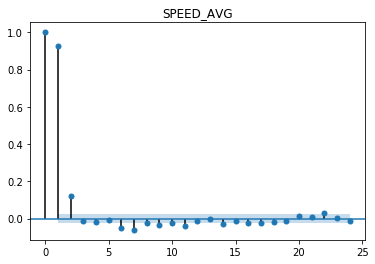

In [19]:
plot_pacf(speed_train[SPEED_AVG], lags=24, title=SPEED_AVG)
plt.show()

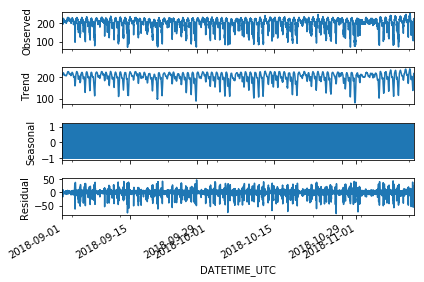

In [20]:
decomposed_temperature = seasonal_decompose(x=speed_train[SPEED_AVG], freq=15)
fig = decomposed_temperature.plot()

In [21]:
model = sm.tsa.ARIMA(speed_train[SPEED_AVG].diff().iloc[1:].values, order=(3,1,0))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 6998
Model:                 ARIMA(3, 1, 0)   Log Likelihood              -28175.607
Method:                       css-mle   S.D. of innovations             13.562
Date:                Fri, 31 May 2019   AIC                          56361.214
Time:                        13:51:09   BIC                          56395.481
Sample:                             1   HQIC                         56373.022
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.060      0.011      0.992      -0.117       0.118
ar.L1.D.y     -0.8739      0.012    -75.690      0.000      -0.897      -0.851
ar.L2.D.y     -0.5680      0.014    -40.538      0.000      -0.595      -0.541
ar.L3.D.y     -0.2589      0.012    -22.418      0.000      -0.281      -0.236
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5957           -0.0000j            1.5957           -0.5000
AR.2           -0.2993           -1.5269j            1.5559           -0.2808
AR.3           -0.2993           +1.5269j            1.5559            0.2808
-----------------------------------------------------------------------------
"""

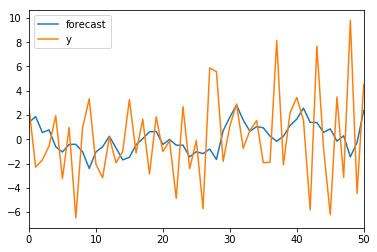

In [22]:
plot = result.plot_predict(start=150, end=200)
plt.show()

In [23]:
train_sample = speed_train[SPEED_AVG]
model = sm.tsa.SARIMAX(train_sample, order=(7,1,0), trend='c')
result = model.fit(maxiter=1000,disp=False)
result.summary()

/Users/gianpaolo/anaconda3/envs/dmtm/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              SPEED_AVG   No. Observations:                 7000
Model:               SARIMAX(7, 1, 0)   Log Likelihood              -27287.117
Date:                Fri, 31 May 2019   AIC                          54592.233
Time:                        13:51:12   BIC                          54653.915
Sample:                             0   HQIC                         54613.488
                               - 7000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0019      0.156      0.012      0.990      -0.304       0.308
ar.L1         -0.1556      0.006    -24.175      0.000      -0.168      -0.143
ar.L2         -0.0159      0.007     -2.174      0.030      -0.030      -0.002
ar.L3         -0.0133      0.007     -1.847      0.065      -0.027       0.001
ar.L4         -0.0195      0.008     -2.317      0.020      -0.036      -0.003
ar.L5          0.0244      0.009      2.619      0.009       0.006       0.043
ar.L6          0.0261      0.009      2.798      0.005       0.008       0.044
ar.L7         -0.0113      0.010     -1.187      0.235      -0.030       0.007
sigma2       142.5826      0.911    156.519      0.000     140.797     144.368
===================================================================================
Ljung-Box (Q):                      111.74   Jarque-Bera (JB):             45671.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.01
Prob(H) (two-sided):                  0.02   Kurtosis:                        15.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/gianpaolo/anaconda3/envs/dmtm/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


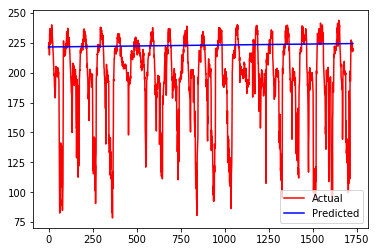

In [35]:
predicted_result = result.forecast(steps = len(speed_test))
plt.plot(speed_test.reset_index()[SPEED_AVG], color='red')
plt.plot(predicted_result.reset_index()[0], color='blue')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [34]:
predicted_result.reset_index()[0]

0       221.494989
1       221.555552
2       221.444030
3       221.394175
4       221.497748
5       221.489096
6       221.484423
7       221.486155
8       221.481156
9       221.486538
10      221.490818
11      221.490505
12      221.492444
13      221.493876
14      221.495439
15      221.497369
16      221.498945
17      221.500526
18      221.502202
19      221.503826
20      221.505481
21      221.507131
22      221.508766
23      221.510411
24      221.512055
25      221.513697
26      221.515341
27      221.516984
28      221.518628
29      221.520271
           ...    
1699    224.264625
1700    224.266269
1701    224.267912
1702    224.269555
1703    224.271199
1704    224.272842
1705    224.274485
1706    224.276129
1707    224.277772
1708    224.279415
1709    224.281058
1710    224.282702
1711    224.284345
1712    224.285988
1713    224.287632
1714    224.289275
1715    224.290918
1716    224.292562
1717    224.294205
1718    224.295848
1719    224.297492
1720    224.